# Install Libraries & Dependencies

In [ ]:
pip install scikit-image

In [ ]:
!pip install scikit-image --upgrade


In [ ]:
import os
import numpy as np
import cv2
import glob
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
import zipfile

zip_file_path = '/content/BraTs18.zip'
extract_path = '/content/BraTs18'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /content/BraTs18


# Data Preprocessing

In [ ]:
images_dir = "/content/BraTs18/brats18/images"
masks_dir = "/content/BraTs18/brats18/masks"

image_files = sorted(glob.glob(os.path.join(images_dir, "image_*.png")))
print(f"Found {len(image_files)} image files: {image_files}")

mask_files = sorted(glob.glob(os.path.join(masks_dir, "mask_*.png")))
print(f"Found {len(mask_files)} mask files: {mask_files}")

Found 5042 image files: ['/content/BraTs18/brats18/images/image_1.png', '/content/BraTs18/brats18/images/image_10.png', '/content/BraTs18/brats18/images/image_100.png', '/content/BraTs18/brats18/images/image_1000.png', '/content/BraTs18/brats18/images/image_1001.png', '/content/BraTs18/brats18/images/image_1002.png', '/content/BraTs18/brats18/images/image_1003.png', '/content/BraTs18/brats18/images/image_1004.png', '/content/BraTs18/brats18/images/image_1005.png', '/content/BraTs18/brats18/images/image_1006.png', '/content/BraTs18/brats18/images/image_1007.png', '/content/BraTs18/brats18/images/image_1008.png', '/content/BraTs18/brats18/images/image_1009.png', '/content/BraTs18/brats18/images/image_101.png', '/content/BraTs18/brats18/images/image_1010.png', '/content/BraTs18/brats18/images/image_1011.png', '/content/BraTs18/brats18/images/image_1012.png', '/content/BraTs18/brats18/images/image_1013.png', '/content/BraTs18/brats18/images/image_1014.png', '/content/BraTs18/brats18/images

In [ ]:
assert len(image_files) == len(mask_files), "Mismatch between images and masks!"

In [ ]:
# Function to load an image as grayscale
def load_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return image

In [ ]:
# Function to normalize an image by scaling pixel values to the range [0, 1]
def normalize_image(image):
    image = image.astype(np.float32)
    return image / 255.0

In [ ]:
# Function to apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance contrast
def enhance_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply((image * 255).astype(np.uint8)) / 255.0

In [ ]:
# Function to resize an image to the target size (default 112x112)
def resize_image(image, target_size=(112, 112)):
    return cv2.resize(image, target_size)

In [ ]:
# Function to preprocess the image by normalizing, enhancing contrast, and resizing
def preprocess_image(file_path, target_size=(112, 112)):
    image = load_image(file_path)
    normalized_image = normalize_image(image)
    enhanced_image = enhance_contrast(normalized_image)
    resized_image = resize_image(enhanced_image, target_size)
    return resized_image

In [ ]:
# Shuffle and split the data into training and validation sets (80%/20%)
combined = list(zip(image_files, mask_files))
random.shuffle(combined)
split_idx = int(len(combined) * 0.8)
train_pairs = combined[:split_idx]
val_pairs = combined[split_idx:]

In [ ]:
# Apply preprocessing to training and validation images
train_images = [preprocess_image(img_path) for img_path, _ in train_pairs]
train_masks = [load_image(mask_path) for _, mask_path in train_pairs]
val_images = [preprocess_image(img_path) for img_path, _ in val_pairs]
val_masks = [load_image(mask_path) for _, mask_path in val_pairs]

In [ ]:
print(f"Sample preprocessed image shape: {train_images[0].shape}")
print(f"Sample mask shape: {train_masks[0].shape}")

Sample preprocessed image shape: (112, 112)
Sample mask shape: (240, 240)


# Exploratory Data Analysis (EDA)

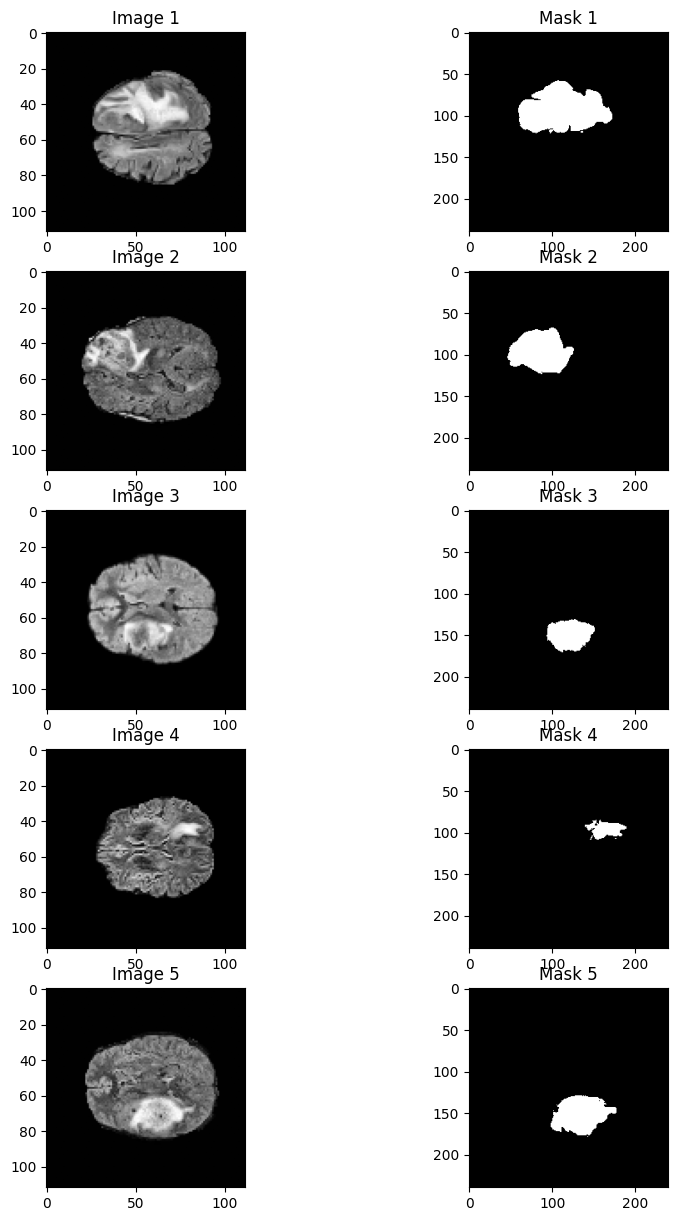

In [ ]:
# Function to display sample images and their corresponding masks
def display_sample_images(images, masks, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 15))
    for i in range(n_samples):
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title(f"Mask {i+1}")
    plt.show()

display_sample_images(train_images, train_masks)

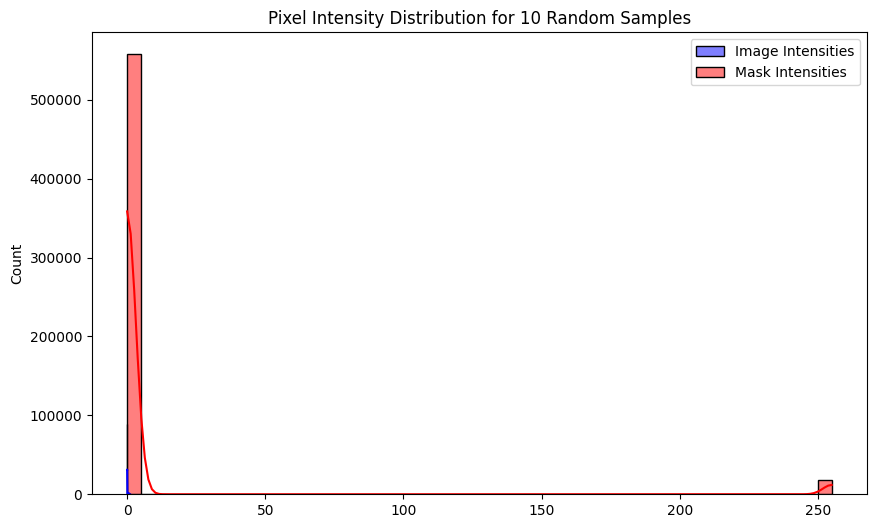

In [ ]:
# Function to plot pixel intensity distribution for a small sample of images and masks
import random
def plot_pixel_intensity_histogram(images, masks, sample_size=10):
    sample_indices = random.sample(range(len(images)), sample_size)
    sample_images = [images[i] for i in sample_indices]
    sample_masks = [masks[i] for i in sample_indices]
    image_intensity = np.concatenate([img.flatten() for img in sample_images])
    mask_intensity = np.concatenate([mask.flatten() for mask in sample_masks])
    plt.figure(figsize=(10, 6))
    sns.histplot(image_intensity, bins=50, color='blue', label='Image Intensities', kde=True)
    sns.histplot(mask_intensity, bins=50, color='red', label='Mask Intensities', kde=True)
    plt.legend()
    plt.title(f'Pixel Intensity Distribution for {sample_size} Random Samples')
    plt.show()

plot_pixel_intensity_histogram(train_images, train_masks, sample_size=10)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from skimage.feature import graycomatrix, graycoprops
import numpy as np

## Feature Engineering Functions
def extract_texture_features(image):
    """Extract texture features using GLCM"""
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    return np.array([contrast, correlation, energy, homogeneity])

def extract_intensity_features(image):
    """Extract intensity-based features"""
    return np.array([
        np.mean(image),
        np.std(image),
        np.median(image),
        np.min(image),
        np.max(image)
    ])

def extract_edge_features(image):
    """Extract edge-based features"""
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    return np.array([
        np.mean(magnitude),
        np.std(magnitude),
        np.max(magnitude)
    ])

def extract_all_features(image):
    """Combine all features into one vector"""
    texture = extract_texture_features(image)
    intensity = extract_intensity_features(image)
    edges = extract_edge_features(image)
    return np.concatenate([texture, intensity, edges])

## Data Preparation with Feature Engineering
def prepare_features(images):
    """Extract features for all images"""
    features = []
    for img in images:
        features.append(extract_all_features(img))
    return np.array(features)

# Extract features
train_features = prepare_features(train_images)
val_features = prepare_features(val_images)

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

## Transfer Learning Model




model2: vgg Learning **Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_vgg_model(input_shape=(112, 112, 1), num_classes=5):
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Fully connected layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate and train
model = build_vgg_model(input_shape=(112, 112, 1), num_classes=5)
model.summary()

# Prepare data
train_images_array = np.array(train_images)[..., np.newaxis].astype(np.float32)
val_images_array = np.array(val_images)[..., np.newaxis].astype(np.float32)

# Define train_labels and val_labels before converting to np.int32
train_labels = np.array([np.argmax(np.bincount(mask.flatten())) for mask in train_masks])  # Define train_labels here
val_labels = np.array([np.argmax(np.bincount(mask.flatten())) for mask in val_masks])  # Define val_labels here

train_labels = train_labels.astype(np.int32)  # Convert to np.int32
val_labels = val_labels.astype(np.int32)  # Convert to np.int32


# Train
history = model.fit(
    train_images_array,
    train_labels,
    epochs=10,
    batch_size=16,
    validation_data=(val_images_array, val_labels),
    verbose=1
)

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 112, 112, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 112, 112, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 5)              │         1,28

 Total params: 26,971,077 (102.89 MB)

 Trainable params: 26,969,285 (102.88 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.9774 - loss: 0.1208 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
253/253 ━━━━━━━━━━━━━━━━━━━

# ***Grad-CAM***

Test images shape: (5, 112, 112, 1)
Test labels shape: (5,)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_128']]
Received: inputs=Tensor(shape=(1, 112, 112, 1))
  warnings.warn(msg)
<ipython-input-58-7403306c6422>:52: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)


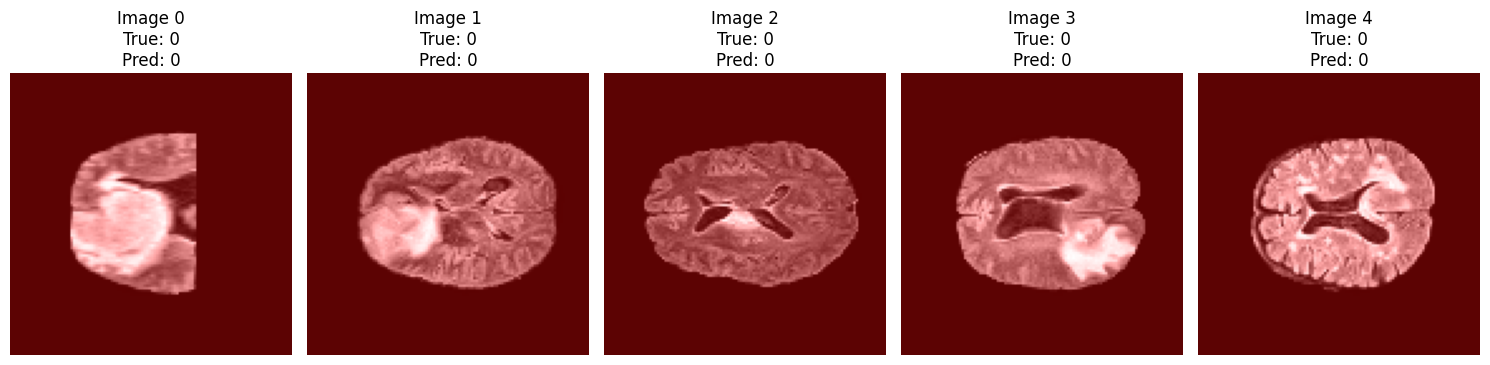

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_gradcam(model, img_tensor, class_idx):
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if 'conv2d' in layer.name:
            last_conv_layer_name = layer.name
            break
    if not last_conv_layer_name:
        raise ValueError("No convolutional layer found. Check model.summary().")

    grad_model = tf.keras.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    cam = tf.maximum(cam, 0)
    cam = cam / tf.reduce_max(cam)

    return cam.numpy()

# Prepare data
x_test = np.array(val_images)[..., np.newaxis].astype(np.float32)
y_test = np.array(val_labels).astype(np.int32)

# Select first 5 images
test_images = x_test[:min(5, len(x_test))]
test_labels = y_test[:min(5, len(y_test))]
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

plt.figure(figsize=(15, 6))
for idx in range(len(test_images)):
    img_tensor = test_images[idx:idx+1]
    pred = model.predict(img_tensor, verbose=0)
    class_idx = np.argmax(pred)

    cam = compute_gradcam(model, img_tensor, class_idx)
    cam = cv2.resize(cam, (112, 112))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap / 255.0

    np_img = test_images[idx].squeeze()
    np_img = np.expand_dims(np_img, axis=-1)
    overlay = 0.7 * heatmap + np_img

    plt.subplot(1, 5, idx+1)
    plt.imshow(overlay)
    plt.title(f"Image {idx}\nTrue: {test_labels[idx]}\nPred: {class_idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
!pip install lime

# ***LIME***

Test images shape: (5, 112, 112, 1)
Test labels shape: (5,)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

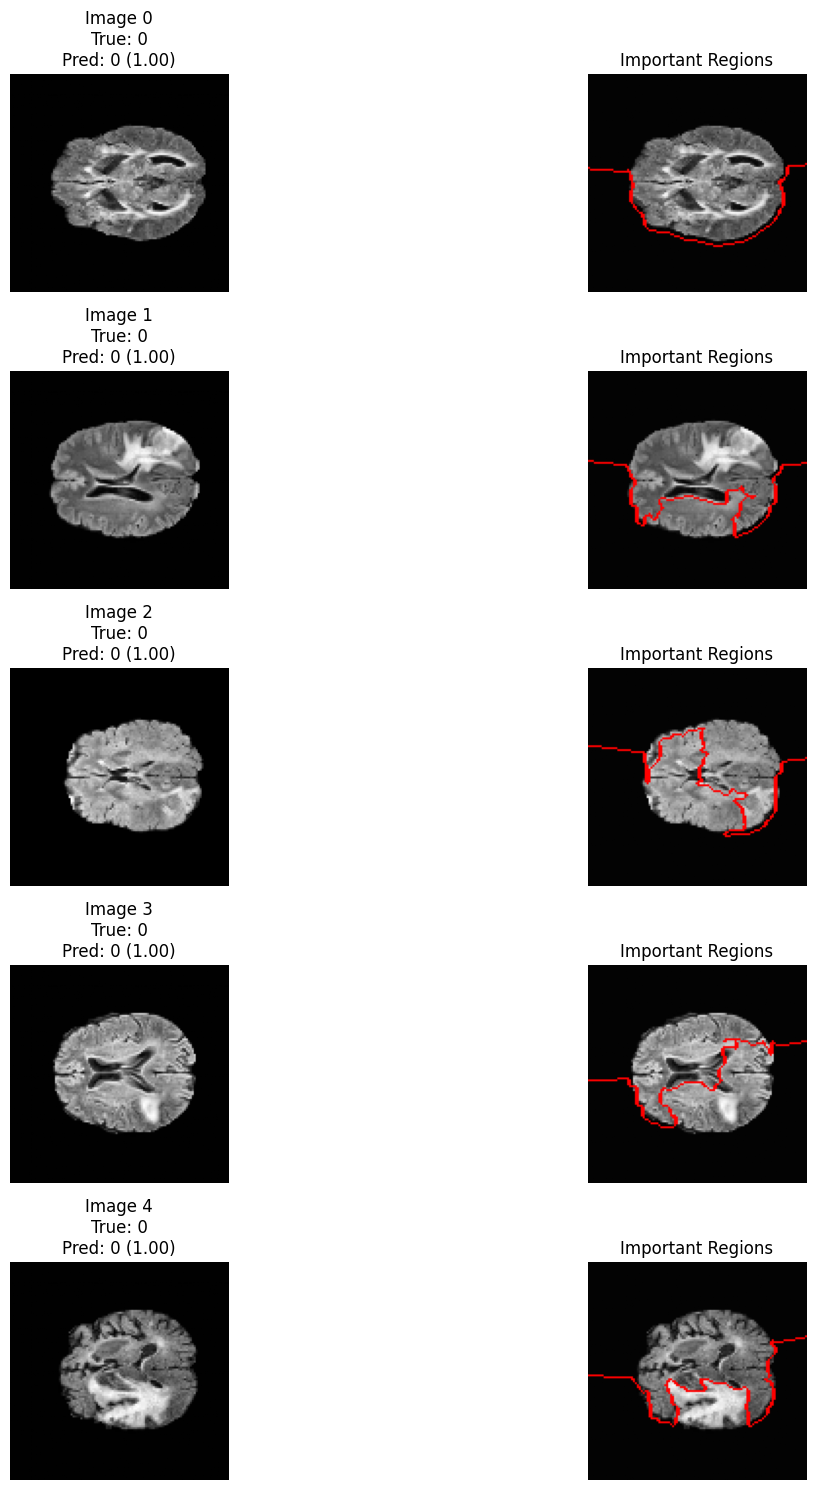

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import slic, mark_boundaries

x_test = np.array(val_images)[..., np.newaxis].astype(np.float32)
y_test = np.array(val_labels).astype(np.int32)

test_images = x_test[:min(5, len(x_test))]
test_labels = y_test[:min(5, len(y_test))]
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

def model_predict(images):
    if images.ndim == 3:
        images = images[..., np.newaxis]
    if images.shape[-1] == 3:
        images = images.mean(axis=-1, keepdims=True)
    return model.predict(images, verbose=0)

explainer = LimeImageExplainer(random_state=42)

def segment_image(image):
    segments = slic(image, n_segments=30, compactness=0.5, sigma=1, start_label=1)
    return segments

plt.figure(figsize=(15, 15))
for idx in range(len(test_images)):
    image = test_images[idx]
    try:
        explanation = explainer.explain_instance(
            image.squeeze(),
            model_predict,
            top_labels=1,
            hide_color=0,
            num_samples=3000,
            segmentation_fn=segment_image
        )
        pred = model_predict(image[np.newaxis, ...])
        pred_class = np.argmax(pred)
        pred_prob = np.max(pred)

        temp, mask = explanation.get_image_and_mask(
            pred_class,
            positive_only=False,
            num_features=10,
            hide_rest=False
        )

        if np.all(mask == 0):
            print(f"Warning: Empty mask for image {idx}. Adjusting segmentation.")
            segments = slic(image.squeeze(), n_segments=20, compactness=0.3, sigma=0.5)
            temp, mask = explanation.get_image_and_mask(
                pred_class, positive_only=False, num_features=10, hide_rest=False, segmentation_fn=lambda x: segments
            )

    except Exception as e:
        print(f"LIME failed for image {idx}: {e}")
        mask = np.zeros_like(image.squeeze())
        temp = image.squeeze()

    plt.subplot(len(test_images), 2, idx*2+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Image {idx}\nTrue: {test_labels[idx]}\nPred: {pred_class} ({pred_prob:.2f})')
    plt.axis('off')

    plt.subplot(len(test_images), 2, idx*2+2)
    boundary_image = mark_boundaries(image.squeeze()/255.0 if image.max() > 1 else image.squeeze(), mask, color=(1, 0, 0), mode='outer')
    plt.imshow(boundary_image, cmap='gray')
    plt.title('Important Regions' if not np.all(mask==0) else 'No Important Regions')
    plt.axis('off')

plt.tight_layout()
plt.show()

# ***SHAP***

Train images min/max: 0.003921569 1.0
Val images min/max: 0.003921569 1.0
Background shape: (20, 112, 112, 1)
Test images shape: (1, 112, 112, 1)
Test images sample: 0.007843138 0.9867947


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_66
Received: inputs=['Tensor(shape=(40, 112, 112, 1))']
  warnings.warn(msg)


SHAP values shape: [(112, 112, 1, 5)]
Number of classes in SHAP values: 1


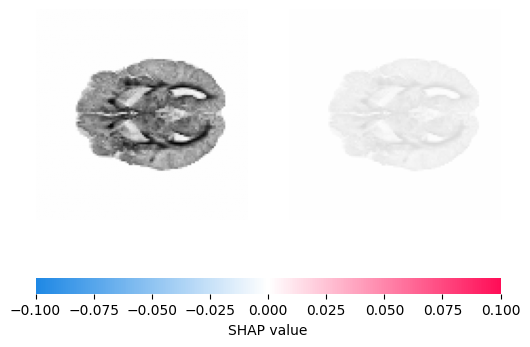

In [ ]:
# Install and import SHAP
!pip install --upgrade shap
import shap
import matplotlib.pyplot as plt
import numpy as np

# Verify data normalization (already in range [0, 1])
print("Train images min/max:", train_images_array.min(), train_images_array.max())
print("Val images min/max:", val_images_array.min(), val_images_array.max())

# Prepare a smaller background dataset
background_size = 20  # Reduced from 100 to save memory
background = train_images_array[np.random.choice(train_images_array.shape[0], background_size, replace=False)]
print("Background shape:", background.shape)

# Select a single test image to explain
num_test_images = 1  # Reduced from 5 to save memory
test_images = val_images_array[:num_test_images]
print("Test images shape:", test_images.shape)
print("Test images sample:", test_images[0].min(), test_images[0].max())

# Create SHAP explainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for the single test image
shap_values = explainer.shap_values(test_images)
print("SHAP values shape:", [v.shape for v in shap_values])
print("Number of classes in SHAP values:", len(shap_values))

# Visualize SHAP values
shap.image_plot(shap_values, -test_images)

# *Google DeepDream*

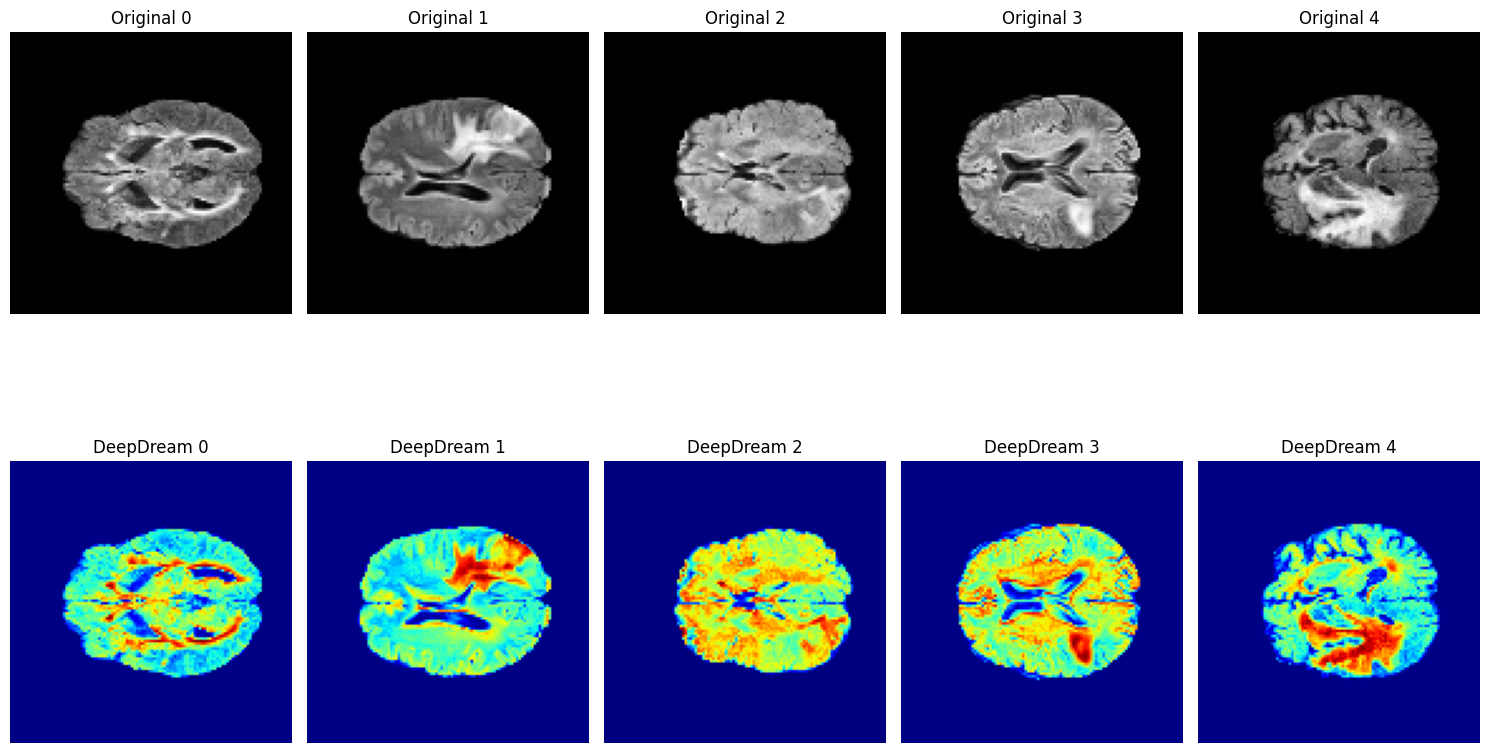

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models

def deep_dream(model, image, steps=100, step_size=0.01):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    for _ in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            activations = model(image[tf.newaxis, ...])
            loss = tf.reduce_mean(activations)
        gradients = tape.gradient(loss, image)
        gradients /= tf.maximum(tf.reduce_mean(tf.abs(gradients)), 1e-7)
        image += gradients * step_size
        image = tf.clip_by_value(image, 0.0, 1.0)
    return image.numpy()

x_test = np.array(val_images)[..., np.newaxis].astype(np.float32)
test_images = x_test[:5]

dreamed_images = []
for img in test_images:
    dreamed_img = deep_dream(model, img, steps=100, step_size=0.01)
    dreamed_images.append(dreamed_img)

plt.figure(figsize=(15, 10))
for idx in range(5):
    plt.subplot(2, 5, idx+1)
    plt.imshow(test_images[idx].squeeze(), cmap='gray')
    plt.title(f'Original {idx}')
    plt.axis('off')
    plt.subplot(2, 5, idx+6)
    plt.imshow(dreamed_images[idx].squeeze(), cmap='jet')
    plt.title(f'DeepDream {idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()